# Kaggle: Titanic Challenge
## Coded by Daniel Wilcox

This is a notebook showing the process in predicting the survivors of the Titanic.

In [1]:
import os
import pickle
import glob

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import randint, reciprocal, expon, uniform

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone

#Fills in values to empty data locations
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Creating custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer




from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


#Classifier Models:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import NuSVC #-----

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier #-----
from sklearn.linear_model import Perceptron #-----
from sklearn.linear_model import RidgeClassifier #-----

from sklearn.gaussian_process import GaussianProcessClassifier #-----

from sklearn.naive_bayes import BernoulliNB #-----
from sklearn.naive_bayes import GaussianNB #-----

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier #-----

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #-----
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #-----

from sklearn.neural_network import MLPClassifier #-----

from sklearn.ensemble import VotingClassifier


In [2]:
#The Location to save the dataset
TITANIC_PATH = "datasets/titanic"
TITANIC_URL = "https://github.com/Daniel-Wilcox/ADA-874-2019/blob/master/datasets/titanic/"
train_name = "train.csv" 
test_name = "test.csv" 


#The Location to save the models
PICKLE_PATH = "PickleModels/Titanic"

In [3]:
#Pickle functions

#Saving and storing the model
def save_pickle(model_name, model, pic_path=PICKLE_PATH):
    print("Saving model...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
        
    f = open(model_name, "wb")
    pickle.dump(model, f)
    f.close()
    
    os.chdir(cwd)
    print("Saved "+model_name+" successfully!\n")
    return None
    
    
#Retrieving and loading the model
def load_pickle(model_name, pic_path=PICKLE_PATH):
    print("Loading "+model_name+" from Pickle file...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
    
    f = open(model_name, "rb")
    p = pickle.load(f)
    f.close()
    
    os.chdir(cwd)
    print(model_name+" successfully loaded!\n")
    return p

#Check whether the pickel exists
def pickle_exist(model_name, pic_path=PICKLE_PATH):
    #check if pickle file exists
    print("Checking if pickle directory exists...")
    if not os.path.isdir(pic_path):
        os.makedirs(pic_path)
        print("Directory does NOT exists")
        print("Creating directory")
    
    else: 
        print("Directory exists")
        
    if os.path.isfile(pic_path+"/"+model_name):
        print("Pickle file does exists...")
        return True
    else:
        print("Pickle file does NOT exists...")
        return False

In [4]:
def load_Titanic_data(file_name, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    return pd.read_csv(csv_path)
        
    
def get_Titanic_data(file_name, titanic_url=TITANIC_URL, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    
    print("Checking if directory exists...")
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)
        print("Creating directory")
    
    else: 
        print("Directory exists") 
            
        if os.path.isfile(csv_path):
            print(file_name + " file does exists...")
            print("extracting " + file_name)
            
            titanic = load_Titanic_data(file_name)
            print("\nSuccess!")
            return titanic
        
        else:
            print(file_name + " file doesn't exists...")
            print("Download .csv from Kaggle!")

            return None
                   

In [5]:
Train = get_Titanic_data(train_name)
Test = get_Titanic_data(test_name)


Checking if directory exists...
Directory exists
train.csv file does exists...
extracting train.csv

Success!
Checking if directory exists...
Directory exists
test.csv file does exists...
extracting test.csv

Success!


In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
Train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Variable - Definition                              - Key
1. survival - Survival                                - 0/1 = No/Yes
2. pclass   - Ticket class                            - 1,2,3 = 1st, 2nd, 3rd class
3. sex      - Sex                                     - male, female
4. Age      - Age in years                            - ...
5. sibsp    - # of siblings/spouses on the Titanic    - ...
6. parch    - # of parents/children on the Titanic    - ...
7. ticket   - Ticket number                           - ...
8. fare     - Passenger fare                          - ...
9. cabin    - Cabin number                            - ...
10. embarked - Port of Embarkation                     - C = Cherbourg, Q = Queenstown, S = Southampton


In [9]:
#It can be seen that there are some features that have NaN values.

In [10]:
Train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [11]:
sur = Train["Survived"].value_counts() / len(Train)
print("{:.2f}% Survived\n{:.2f}% Died".format(100*sur[1],100*sur[0]))

38.38% Survived
61.62% Died


In [12]:
#Correlation matrix (numeric features)
corr_matrix = Train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [13]:
#Full Titanic dataset analysis:
titanic = Train.append(Test, ignore_index=True)

#Age: fill
titanic["Age"] = titanic["Age"].fillna(titanic["Fare"].median())

#Cabin:
titanic["Cabin"] = titanic["Cabin"].fillna('U')
titanic["Cabin"] = titanic["Cabin"].map(lambda x: x[0])

#Embarked: fill
most_embarked = titanic["Embarked"].value_counts().index[0]
titanic["Embarked"] = titanic["Embarked"].fillna(most_embarked)

#Fare: fill 
titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())

#Name:
form_name = lambda x: x.split(',')[1].split('.')[0].strip()
titanic["Title"] = titanic["Name"].map(form_name)

titanic["Title"] = titanic["Title"].replace(['Don', 
        'Rev', 'Dr', 'Mme', 'Major', 'Lady', 
        'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
        'Jonkheer', 'Dona'], 'Rare')

titanic["Title"] = titanic["Title"].replace(['Mrs',
        'Miss', 'Ms'], 'Girls/Women')

titanic["Title"] = titanic["Title"].replace(['Master'],
        'Boys')

titanic["Title"] = titanic["Title"].replace(['Mr'],
        'Men')

titanic.isnull().sum()


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Title            0
dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


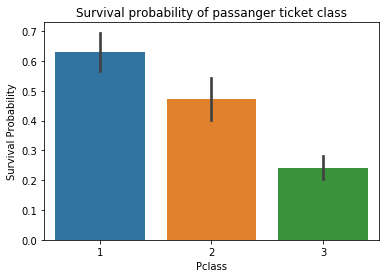

In [14]:
#Pclass

fig = sns.barplot(x="Pclass",y="Survived",data=Train)
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class")


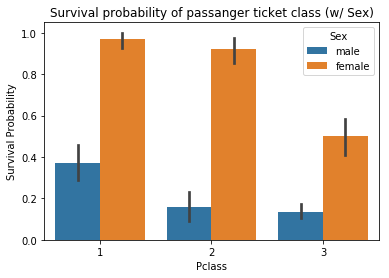

In [15]:
#Pclass w/ Sex

fig = sns.barplot(x="Pclass",y="Survived", hue="Sex", data=Train)
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class (w/ Sex)")


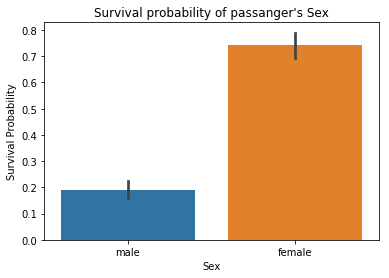

In [16]:
#Sex
fig = sns.barplot(x="Sex",y="Survived",data=Train)
fig = fig.set(xlabel="Sex", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger's Sex")


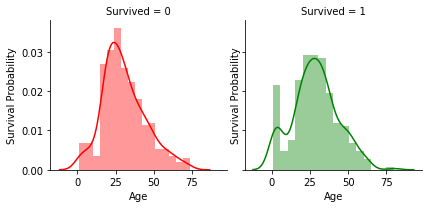

In [17]:
#Age

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(Train, col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Age")   

fig = fig.set(xlabel="Age", ylabel="Survival Probability")

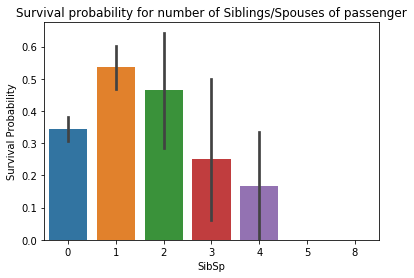

In [18]:
#SibSp

fig = sns.barplot(x="SibSp",y="Survived",data=Train)
fig = fig.set(xlabel="SibSp", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Siblings/Spouses of passenger")


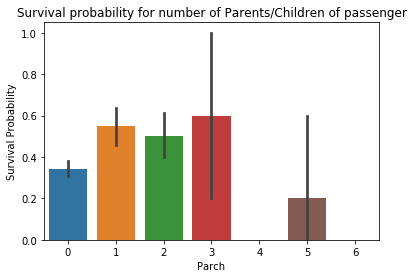

In [19]:
#Parch

fig = sns.barplot(x="Parch",y="Survived",data=Train)
fig = fig.set(xlabel="Parch", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Parents/Children of passenger")


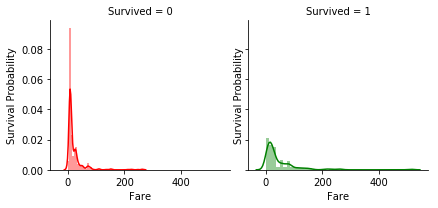

In [20]:
#Fare

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(Train, col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Fare")   

fig = fig.set(xlabel="Fare", ylabel="Survival Probability")

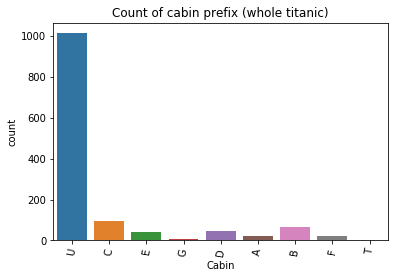

In [21]:
#Cabin
fig = sns.countplot(x="Cabin",data=titanic)
fig = plt.setp(fig.get_xticklabels(), rotation=80) 
fig = plt.title("Count of cabin prefix (whole titanic)")

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


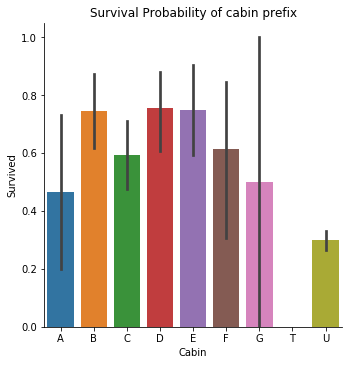

In [22]:
order_cabin = ['A','B','C','D','E','F','G','T','U']
fig = sns.factorplot(x="Cabin", y="Survived", data=titanic,
                    kind="bar", order=order_cabin)
fig = plt.title("Survival Probability of cabin prefix")


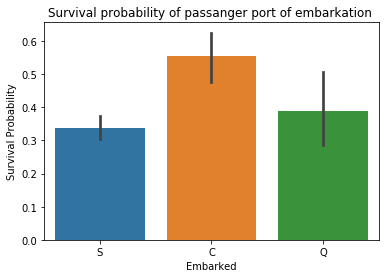

In [23]:
#Embarked

fig = sns.barplot(x="Embarked",y="Survived",data=Train)
fig = fig.set(xlabel="Embarked", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger port of embarkation ")


In [24]:
#feature eng:
Full_set = pd.concat(objs=[Train, Test], axis=0).reset_index(drop=True)

#Name: f_name, honorifics. sur_name
honorifics = [i.split(",")[1].split(".")[0].strip() for i in Full_set["Name"]]
Full_set["Title"] = pd.Series(honorifics)
Full_set.Title.unique()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

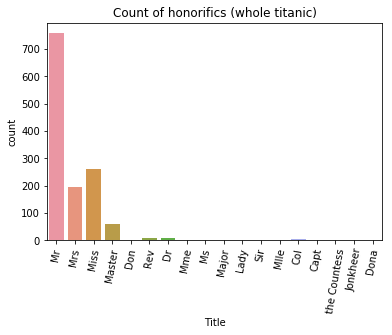

In [25]:
fig = sns.countplot(x="Title",data=Full_set)
fig = plt.setp(fig.get_xticklabels(), rotation=80) 
fig = plt.title("Count of honorifics (whole titanic)")


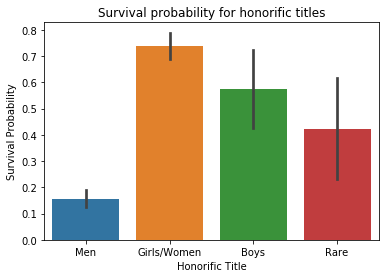

In [26]:
fig = sns.barplot(x="Title",y="Survived",data=titanic)
fig = fig.set(xlabel="Honorific Title", ylabel="Survival Probability")
fig = plt.title("Survival probability for honorific titles")

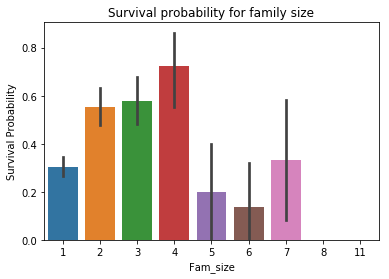

In [27]:
#Family size

Full_set["Fam_size"] = Full_set["SibSp"] + Full_set["Parch"] + 1

fig = sns.barplot(x="Fam_size",y="Survived", data=Full_set)
fig = fig.set(xlabel="Fam_size", ylabel="Survival Probability")
fig = plt.title("Survival probability for family size")

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


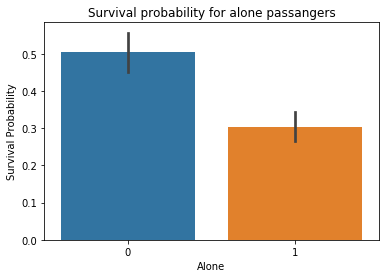

In [28]:
#Alone
Full_set["Alone"] = 1
Full_set["Alone"].loc[Full_set['Fam_size'] > 1] = 0

fig = sns.barplot(x="Alone",y="Survived", data=Full_set)
fig = fig.set(xlabel="Alone", ylabel="Survival Probability")
fig = plt.title("Survival probability for alone passangers")

In [29]:
Train.shape

(891, 12)

In [30]:
#Separtate labels from features
y_train = Train["Survived"].copy()
X_tr = Train.drop("Survived", axis=1)
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [31]:
#Remove Features (survived is already removed)
list_drop = ['Name', 'Ticket', 'Pclass', 'Cabin']
list_excl = ['Ticket'] 

add_fam_feat = True
add_alone = True 
add_title = True
fix_cabin = True
    
Dropped = X_tr[list(set(X_tr.columns) - set(list_drop))]

#Numeric Features
list_num = Dropped.select_dtypes(include = ["number"]).columns

#Catagorical Features (to be transformed into OHE)
list_cat = Dropped.select_dtypes(include = ["object"]).columns

list_add = X_tr[list(set(X_tr.columns) - set(list_excl))].columns


if add_fam_feat:
    list_num = list_num.insert(len(list_num)+ 1,'Fam_size')
    
if add_alone:
    list_num = list_num.insert(len(list_num)+1,'Alone')    
    
if add_title:
    list_cat = list_cat.insert(len(list_num)+1,'Title')
    
if fix_cabin:
    new_cabin = 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'
    for i in new_cabin:
        list_num = list_num.insert(len(list_num)+1, i)
    
    
    
list_cat = list_cat.insert(len(list_num)+1,'Pclass')

print('list_num: {}'.format(list(list_num)))
print('list_cat: {}'.format(list(list_cat)))
print('list_add: {}'.format(list(list_add)))

list_num: ['Fare', 'PassengerId', 'SibSp', 'Age', 'Parch', 'Fam_size', 'Alone', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U']
list_cat: ['Sex', 'Embarked', 'Title', 'Pclass']
list_add: ['Sex', 'Fare', 'PassengerId', 'SibSp', 'Embarked', 'Age', 'Name', 'Parch', 'Cabin', 'Pclass']


In [32]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return(self)
    
    def transform(self, X):
        return X[self.feature_names].values
    
    
    
class add_features(BaseEstimator, TransformerMixin):
    def __init__(self, added_feat, add_fam=True, 
                 add_alone=True, add_title=True,
                 fix_cabin = True):
        
        self.added_feat = added_feat
        self.add_fam = add_fam
        self.add_alone = add_alone
        self.add_title = add_title
        self.fix_cabin = fix_cabin
   

    def fit(self, X, y=None):
        return(self)

    
    def transform(self, X):  
        df = X[self.added_feat]
        
        if self.fix_cabin:
            df["Cabin"] = df["Cabin"].fillna('U')
            df["Cabin"] = df["Cabin"].map(lambda x: x[0])
            
            for i in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'):
                df[i] = 0
                df[i].loc[df["Cabin"] == i] = 1
            
            df.drop(labels=["Cabin"], axis = 1, 
                   inplace = True)
            
            
        if self.add_fam:
            df["Fam_size"] = df.loc[:,"SibSp"] + df.loc[:,"Parch"] + 1
            
        if self.add_alone:
            df["Alone"] = 0
            df["Alone"].loc[(df["SibSp"]==0) & 
                           (df["Parch"]==0)] = 1
            
        if self.add_title:
            honorifics = [i.split(",")[1].split(".")[0].
                          strip() for i in df["Name"]]
            
            df["Title"] = pd.Series(honorifics)
            
            df["Title"] = df.loc[:,"Title"].replace(
                ['Don', 'Rev', 'Dr', 'Mme', 'Major', 
                 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                 'the Countess', 'Jonkheer', 'Dona'],
                 'Rare')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Mrs','Miss','Ms'], 'Girls/Women')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Master'], 'Boys')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Mr'], 'Men') 
            
            df.drop(labels=["Name"], axis = 1, 
                   inplace = True)

        return df 

In [33]:
#Add Features
add_pipeline = Pipeline([
    ('add_feat', add_features(list_add))
])

#Numeric Transformations
num_pipeline = Pipeline([
    ('selector', Selector(list_num)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

#Catagorical Transformations
cat_pipeline = Pipeline([
    ('selector', Selector(list_cat)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [34]:
a = add_pipeline.fit_transform(X_tr)
b = add_pipeline.fit_transform(Test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
print('Transformed Dataframe: {}'.format(list(a.columns)))

Transformed Dataframe: ['Sex', 'Fare', 'PassengerId', 'SibSp', 'Embarked', 'Age', 'Parch', 'Pclass', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U', 'Fam_size', 'Alone', 'Title']


In [36]:
a.head(5)

,Sex,Fare,PassengerId,SibSp,Embarked,Age,Parch,Pclass,A,B,C,D,E,F,G,T,U,Fam_size,Alone,Title
0,male,7.2500,1,1,S,22.0,0,3,0,0,0,0,0,0,0,0,1,2,0,Men
1,female,71.2833,2,1,C,38.0,0,1,0,0,1,0,0,0,0,0,0,2,0,Girls/Women
2,female,7.9250,3,0,S,26.0,0,3,0,0,0,0,0,0,0,0,1,1,1,Girls/Women
3,female,53.1000,4,1,S,35.0,0,1,0,0,1,0,0,0,0,0,0,2,0,Girls/Women
4,male,8.0500,5,0,S,35.0,0,3,0,0,0,0,0,0,0,0,1,1,1,Men


In [37]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
Sex            891 non-null object
Fare           891 non-null float64
PassengerId    891 non-null int64
SibSp          891 non-null int64
Embarked       889 non-null object
Age            714 non-null float64
Parch          891 non-null int64
Pclass         891 non-null int64
A              891 non-null int64
B              891 non-null int64
C              891 non-null int64
D              891 non-null int64
E              891 non-null int64
F              891 non-null int64
G              891 non-null int64
T              891 non-null int64
U              891 non-null int64
Fam_size       891 non-null int64
Alone          891 non-null int64
Title          891 non-null object
dtypes: float64(2), int64(15), object(3)
memory usage: 139.3+ KB


In [38]:
b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
Sex            418 non-null object
Fare           417 non-null float64
PassengerId    418 non-null int64
SibSp          418 non-null int64
Embarked       418 non-null object
Age            332 non-null float64
Parch          418 non-null int64
Pclass         418 non-null int64
A              418 non-null int64
B              418 non-null int64
C              418 non-null int64
D              418 non-null int64
E              418 non-null int64
F              418 non-null int64
G              418 non-null int64
T              418 non-null int64
U              418 non-null int64
Fam_size       418 non-null int64
Alone          418 non-null int64
Title          418 non-null object
dtypes: float64(2), int64(15), object(3)
memory usage: 65.4+ KB


In [39]:
perpare_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

full_pipe = Pipeline([
    ("add_pipeline", add_pipeline),
    ("prep_pipeline", perpare_pipeline)
])

X_train = full_pipe.fit_transform(X_tr)
X_train.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(891, 28)

In [40]:
#Scaled Test Set for predictions:
X_test = full_pipe.fit_transform(Test)
X_test.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(418, 28)

In [41]:
#To create new model if pickle already even if pickle exists; load_pkl = False
load_pkl = True

cv_split=StratifiedKFold(n_splits=10)
cv_split

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [42]:
def model_cross_val(clf, name_clf, lp=load_pickle):
    if pickle_exist(str(name_clf)) and (lp==True):
        ml_clf = load_pickle(str(name_clf))
    else:
        ml_clf = clf
        ml_clf.fit(X_train, y_train)
        save_pickle(str(name_clf), ml_clf)
    cvs =  cross_val_score(ml_clf, X_train, y_train, cv=cv_split, scoring="accuracy") 
    return  np.mean(cvs)


In [43]:
clf_options = [          
    LinearSVC(), #no proba
    SVC(probability=True),
    NuSVC(probability=True),
    
    LogisticRegression(),
    SGDClassifier(),
    PassiveAggressiveClassifier(), #no proba
    Perceptron(), #no proba
    RidgeClassifier(), #no proba
    
    GaussianProcessClassifier(),
    
    BernoulliNB(),
    GaussianNB(),
    
    DecisionTreeClassifier(),
    
    KNeighborsClassifier(),
    
    
    RandomForestClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(),
                       learning_rate=0.1),
    
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier(),
    
    LinearDiscriminantAnalysis(),

    MLPClassifier()

] 
 

   
compare_col = ['Clf Name', 'Clf Parameters', 'Clf Mean Accuracy'] 
clf_compare = pd.DataFrame(columns = compare_col)
                 
row=0
          
for clf in clf_options: 
    clf_name = clf.__class__.__name__
                    
    clf_compare.loc[row, 'Clf Name'] = clf_name
    clf_compare.loc[row, 'Clf Parameters'] = str(clf.get_params()) 
    cvs = model_cross_val(clf, clf_name)
    
    clf_compare.loc[row, 'Clf Mean Accuracy'] = cvs
    
    row +=1

               

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LinearSVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved NuSVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LogisticRegression successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SGDClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved PassiveAggressiveClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved Perceptron successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved RidgeClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GaussianProcessClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved BernoulliNB successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GaussianNB successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved DecisionTreeClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved KNeighborsClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved RandomForestClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved AdaBoostClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved ExtraTreesClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GradientBoostingClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved BaggingClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LinearDiscriminantAnalysis successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...


/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.7/site-packages/sklearn

Saving model...
Saved MLPClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [44]:
clf_compare.sort_values(by = 'Clf Mean Accuracy', ascending = False, inplace = True)
clf_compare

,Clf Name,Clf Parameters,Clf Mean Accuracy
0,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.830596
7,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.830583
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.829459
3,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.828361
19,MLPClassifier,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.82494
13,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.819359
15,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.816038
1,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.814928
16,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.814928
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.813803


In [49]:
#Parameters of classifiers (Random Search):

#Linear SVC
lin_svc_rs = {
    'loss' : ['hinge','squared_hinge'],
    'C' : reciprocal(0.01, 1000)
}


#SVC
svc_rs = {
    'C' : reciprocal(0.01, 1000),
    'kernel' : ['linear', 'rbf'],
    'gamma' : reciprocal(0.01, 10000)
}

#NuSVC
nuSVC_rs = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : reciprocal(0.01, 10000),
}



#Logistic Regression
log_reg_rs = {
    'penalty' : ['l1', 'l2'],
    'C' : reciprocal(0.01, 1000) 
}

#SGDClassifier
SGDC_rs = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha': reciprocal(0.1, 10000), 
    'warm_start' : [True, False]
}




#PassiveAggressiveClassifier
pass_rs = {
    'C' : reciprocal(0.01, 1000),
    'fit_intercept' : [True, False]
}


#Perceptron
perc_rs = {
    'alpha': reciprocal(0.1, 10000), 
    'fit_intercept' : [True, False],
    'shuffle' : [True, False],
    'warm_start' : [True, False]
}


#RidgeClassifier
ridge_rs = {
    'alpha': reciprocal(0.1, 10000)
}

#GaussianProcessClassifier
gaus_rs = {
    'warm_start' : [True, False]
}

    
#BernoulliNB
bernNB_rs = {
    'alpha': reciprocal(0.1, 10000),
    'binarize': reciprocal(0.1, 10000),
    'fit_prior' : [True, False]
    
}


#GaussianNB
guasNB_rs = {
    'var_smoothing': reciprocal(1, 1000000),
}

#Decision Tree Classifier
tree_rs = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 10),
    'min_samples_leaf' : randint(1, 10),
    'max_features' : randint(1, 10)
}

  
#K-Neighbors Classifier
k_neigh_rs = {
    'n_neighbors': randint(3, 15),
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : randint(2, 100),
    'p' : randint(1, 2)
}

#Random Forest Classifier
forest_rs = {
    'n_estimators' : randint(10, 500),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_features' : randint(1, 15)
}
    
#AdaBoost Classifier
ada_rs = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : randint(1, 50),
    'learning_rate' : reciprocal(0.6, 10000),
    'algorithm' : ['SAMME', 'SAMME.R']
    
}


#Extra Trees Classifier
extra_tree_rs = {
    'n_estimators' : randint(10, 500),
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : randint(2, 10),
    'min_samples_leaf' : randint(1, 10),
    'max_features' : randint(1, 10)    
    
}


#Gradient Boosting Classifier
grad_boost_rs = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : reciprocal(0.6, 10000),
    'n_estimators' : randint(10, 500),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_depth': randint(3, 15),
    'max_features' : randint(1, 15)
    
}  


bag_rs = {
    'n_estimators' : randint(10, 50)
}

#LinearDiscriminantAnalysis
linDes_rs = {
    'solver' : ['svd']
}
    
#QuadraticDiscriminantAnalysis
quadDes_rs = {
    'reg_param' : 0.0
}


#MLPClassifier
MLPC_rs = {
    'hidden_layer_sizes' : randint(10, 1000),
    'alpha': reciprocal(0.1, 10000),
    'warm_start' : [True, False]
}



param_option_rs = [
    lin_svc_rs,
    svc_rs,
    nuSVC_rs,
    log_reg_rs,
    SGDC_rs,
    pass_rs,
    perc_rs,
    ridge_rs,
    gaus_rs,
    bernNB_rs,
    guasNB_rs,
    tree_rs,
    k_neigh_rs,
    forest_rs,
    ada_rs,
    extra_tree_rs,
    grad_boost_rs, 
    bag_rs,
    linDes_rs,
    MLPC_rs
    
    
]


In [50]:
#-------------------------------------------------------------------------------
def model_rand_gs(clf, name_clf, clf_param, lp=load_pickle): 

    rand_clf = RandomizedSearchCV(clf, param_distributions=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, n_iter=100, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)
    
    best_est = rand_clf.best_estimator_
    best_sco = rand_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_rs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt(
            (PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_rs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_rs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(
            PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_rs_"+str(name_clf), best_est)


In [51]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_compare_rs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_rs): 
    
    clf_name = clf.__class__.__name__
    best_compare_rs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    
    #model_grid(clf, clf_name, param)
    model_rand_gs(clf, clf_name, param)
   
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_rs_"+str(clf_name))
    
    print("{}: {}\n".format(clf_name, best_clf.get_params))
        
    best_compare_rs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_rs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1
                    

0: LinearSVC
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:    9.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LinearSVC successfully!

Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

LinearSVC: <bound method BaseEstimator.get_params of LinearSVC(C=1.1353133343719801, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)>

1: SVC
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.3min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_SVC successfully!

Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

SVC: <bound method BaseEstimator.get_params of SVC(C=5.692764792921572, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.014365032614839502,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)>

2: NuSVC
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   37.8s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_NuSVC successfully!

Loading best_rs_NuSVC from Pickle file...
best_rs_NuSVC successfully loaded!

NuSVC: <bound method BaseEstimator.get_params of NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=0.038720677477080634,
   kernel='rbf', max_iter=-1, nu=0.5, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)>

3: LogisticRegression
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LogisticRegression successfully!

Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

LogisticRegression: <bound method BaseEstimator.get_params of LogisticRegression(C=0.7902345776553784, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)>

4: SGDClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_SGDClassifier successfully!

Loading best_rs_SGDClassifier from Pickle file...
best_rs_SGDClassifier successfully loaded!

SGDClassifier: <bound method BaseEstimator.get_params of SGDClassifier(alpha=0.38481882065498585, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)>

5: PassiveAggressiveClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_PassiveAggressiveClassifier successfully!

Loading best_rs_PassiveAggressiveClassifier from Pickle file...
best_rs_PassiveAggressiveClassifier successfully loaded!

PassiveAggressiveClassifier: <bound method BaseEstimator.get_params of PassiveAggressiveClassifier(C=0.023667291678445643, average=False,
              class_weight=None, early_stopping=False, fit_intercept=True,
              loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
              n_jobs=None, random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)>

6: Perceptron
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_Perceptron successfully!

Loading best_rs_Perceptron from Pickle file...
best_rs_Perceptron successfully loaded!

Perceptron: <bound method BaseEstimator.get_params of Perceptron(alpha=25.48326241018583, class_weight=None, early_stopping=False,
      eta0=1.0, fit_intercept=False, max_iter=None, n_iter=None,
      n_iter_no_change=5, n_jobs=None, penalty=None, random_state=0,
      shuffle=False, tol=None, validation_fraction=0.1, verbose=0,
      warm_start=True)>

7: RidgeClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.2s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_RidgeClassifier successfully!

Loading best_rs_RidgeClassifier from Pickle file...
best_rs_RidgeClassifier successfully loaded!

RidgeClassifier: <bound method BaseEstimator.get_params of RidgeClassifier(alpha=0.2555812234059024, class_weight=None, copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=None, solver='auto', tol=0.001)>

8: GaussianProcessClassifier
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.8s finished


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GaussianProcessClassifier successfully!

Loading best_rs_GaussianProcessClassifier from Pickle file...
best_rs_GaussianProcessClassifier successfully loaded!

GaussianProcessClassifier: <bound method BaseEstimator.get_params of GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=True)>

9: BernoulliNB
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_BernoulliNB successfully!

Loading best_rs_BernoulliNB from Pickle file...
best_rs_BernoulliNB successfully loaded!

BernoulliNB: <bound method BaseEstimator.get_params of BernoulliNB(alpha=0.2258438859620728, binarize=0.55618208399909,
      class_prior=None, fit_prior=True)>

10: GaussianNB
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GaussianNB successfully!

Loading best_rs_GaussianNB from Pickle file...
best_rs_GaussianNB successfully loaded!

GaussianNB: <bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=2.8089308015120573)>

11: DecisionTreeClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_DecisionTreeClassifier successfully!

Loading best_rs_DecisionTreeClassifier from Pickle file...
best_rs_DecisionTreeClassifier successfully loaded!

DecisionTreeClassifier: <bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')>

12: KNeighborsClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_KNeighborsClassifier successfully!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

KNeighborsClassifier: <bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=88, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=1,
           weights='distance')>

13: RandomForestClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_RandomForestClassifier successfully!

Loading best_rs_RandomForestClassifier from Pickle file...
best_rs_RandomForestClassifier successfully loaded!

RandomForestClassifier: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

14: AdaBoostClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_AdaBoostClassifier successfully!

Loading best_rs_AdaBoostClassifier from Pickle file...
best_rs_AdaBoostClassifier successfully loaded!

AdaBoostClassifier: <bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=92.12167742453491, n_estimators=48,
          random_state=None)>

15: ExtraTreesClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_ExtraTreesClassifier successfully!

Loading best_rs_ExtraTreesClassifier from Pickle file...
best_rs_ExtraTreesClassifier successfully loaded!

ExtraTreesClassifier: <bound method BaseEstimator.get_params of ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=7, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=47, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

16: GradientBoostingClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_GradientBoostingClassifier successfully!

Loading best_rs_GradientBoostingClassifier from Pickle file...
best_rs_GradientBoostingClassifier successfully loaded!

GradientBoostingClassifier: <bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6670512539636684, loss='deviance',
              max_depth=13, max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=177,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

17: BaggingClassifier
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.8s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_BaggingClassifier successfully!

Loading best_rs_BaggingClassifier from Pickle file...
best_rs_BaggingClassifier successfully loaded!

BaggingClassifier: <bound method BaseEstimator.get_params of BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=43, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)>

18: LinearDiscriminantAnalysis
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_LinearDiscriminantAnalysis successfully!

Loading best_rs_LinearDiscriminantAnalysis from Pickle file...
best_rs_LinearDiscriminantAnalysis successfully loaded!

LinearDiscriminantAnalysis: <bound method BaseEstimator.get_params of LinearDiscrimi

[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.8min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWar

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved best_rs_MLPClassifier successfully!

Loading best_rs_MLPClassifier from Pickle file...
best_rs_MLPClassifier successfully loaded!

MLPClassifier: <bound method BaseEstimator.get_params of MLPClassifier(activation='relu', alpha=0.42390546485720554, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=325, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)>



/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [52]:
#Random Grid-search
best_compare_rs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_compare_rs


,Clf Name,Best Clf Parameters,Best Clf Accuracy Score
15,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.836139
17,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.835017
13,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.835017
7,RidgeClassifier,"{'alpha': 0.2555812234059024, 'class_weight': ...",0.83165
0,LinearSVC,"{'C': 1.1353133343719801, 'class_weight': None...",0.830527
1,SVC,"{'C': 5.692764792921572, 'cache_size': 200, 'c...",0.830527
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.829405
3,LogisticRegression,"{'C': 0.7902345776553784, 'class_weight': None...",0.829405
5,PassiveAggressiveClassifier,"{'C': 0.023667291678445643, 'average': False, ...",0.826038
11,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.823793


In [ ]:
#Parameters of classifiers (Grid Search):

#Linear SVC
lin_svc_param = {
    'loss' : ['hinge','squared_hinge'],
    'C' : [1, 2, 5, 10]
}

#SVC
svc_param = {
    'C' : [1, 2, 5, 10],
    'kernel' : ['linear', 'rbf'],
    'gamma' : [ 0.001, 0.01, 0.1, 1]
}

#NuSVC
svc_param = {
    'kernel' : ['linear', 'rbf'],
    'gamma' : [ 0.001, 0.01, 0.1, 1]
}

#Logistic Regression
log_reg_param = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 2, 5, 10]
}

#Decision Tree Classifier
tree_param = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : [1, 2, 3, 5],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [1, 5, 10]
}

#Random Forest Classifier
forest_param = {
    'n_estimators' : [10, 50, 100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 5],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [1, 5, 10]
}

#SGDClassifier
SGDC_param = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha' : [0.001, 0.01, 0.1, 1],
    'warm_start' : [True, False]
}

#K-Neighbors Classifier
k_neigh_param = {
    'n_neighbors': [3, 4, 5, 10],
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 10, 50, 100],
    'p' : [1, 2]
}

#AdaBoost Classifier
ada_param = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : [1, 2, 5, 10, 50],
    'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm' : ['SAMME', 'SAMME.R']
    
}

#Extra Trees Classifier
extra_tree_param = {
    'n_estimators' : [100, 200, 300, 500],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 5,10],
    'max_features' : [1, 5, 10]    
    
}

#Gradient Boosting Classifier
grad_boost_param = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [100, 200],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 10, 100],
    'max_depth': [3, 5, 10],
    'max_features': [0.1, 0.3]
    
}   

               
                
param_option_gs = [
    lin_svc_param, #-
    svc_param, #-
    nuSVC_param, #-
    log_reg_param, #-
    SGDC_param, #-
    pass_param,
    perc_param,
    ridge_param,
    gaus_param,
    bernNB_param,
    guasNB_param,
    tree_param,
    k_neigh_param,
    forest_param,
    ada_param,
    extra_tree_param,
    grad_boost_param,
    bag_param,
    linDes_param,
    MLPC_param
]

In [ ]:

def model_grid(clf, name_clf, clf_param, lp=load_pickle): 

    gs_clf = GridSearchCV(clf, param_grid=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, scoring='accuracy')
    
    gs_clf.fit(X_train, y_train)
    
    best_est = gs_clf.best_estimator_
    best_sco = gs_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_gs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_gs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_gs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_gs_"+str(name_clf), best_est)

    
    

In [ ]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_compare_gs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_gs): 

    
    clf_name = clf.__class__.__name__
    best_compare_rs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    model_grid(clf, clf_name, param)
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_gs_"+str(clf_name))
    
    best_compare_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_gs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1

In [ ]:
#After Gridseach
best_compare_gs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_compare_gs

In [ ]:
def load_best_clf(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return load_pickle("best_gs_"+str(clf_name))
    else:
        return load_pickle("best_rs_"+str(clf_name))

    
    
def load_best_score(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return gs_score
    else:
        return rs_score

In [ ]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_rs_or_gs = pd.DataFrame(columns = best_col)
row=0

for clf in clf_options:
    clf_name = clf.__class__.__name__
    best_rs_or_gs.loc[row, 'Clf Name'] = clf_name
    
    best_clf  = load_best_clf(clf)
    best_score = load_best_score(clf)
    
    best_rs_or_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_rs_or_gs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1
    
best_rs_or_gs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_rs_or_gs    

In [ ]:
#Feature importance:

#NOTE: add val set and retrain


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, ver_index in split.split(Train, Train["Survived"]):
    Train_strat = Train.loc[train_index]
    Ver_strat = Train.loc[ver_index]

print("Training set: {} entries, Verificaiton set: {} entries".format(len(Train_strat),len(Ver_strat)))

In [ ]:
y_training = Train_strat["Survived"].copy()
X_tr = Train_strat.drop("Survived", axis=1)
X_training = full_pipe.fit_transform(X_tr)

y_verification = Ver_strat["Survived"].copy()
X_ver = Ver_strat.drop("Survived", axis=1)
X_verification = full_pipe.fit_transform(X_ver)

In [ ]:
#lin_svc = load_best_clf(clf_options[0])
svc = load_best_clf(clf_options[1])
log_reg = load_best_clf(clf_options[2])
tree = load_best_clf(clf_options[3])
forest = load_best_clf(clf_options[4])
SGDC = load_best_clf(clf_options[5])
knn = load_best_clf(clf_options[6])
ada = load_best_clf(clf_options[7])
etree = load_best_clf(clf_options[8])
gradb = load_best_clf(clf_options[9])
#XGBC = load_best_clf(clf_options[10])

svc.set_params(probability=True)

    
est = [('lin_svc', lin_svc), ('svc', svc), ('log_reg', log_reg),
       ('forest', forest), ('SGDC', SGDC), ('tree', tree),
       ('ada', ada), ('etree', etree), ('knn', knn),
       ('gradb', gradb)]#, ('XGBC', XGBC)]



vote_clf = VotingClassifier(estimators=est, voting='hard')

vote_clf.fit(X_training, y_training)


In [ ]:
for clf in (lin_svc, svc, log_reg, forest, 
            SGDC, tree, ada, etree, knn, 
            gradb, vote_clf):#, XGBC, vote_clf):

    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_verification)
    
    name = clf.__class__.__name__
    score = accuracy_score(y_verification, y_pred)
    
    print("{}: {:.2f}%".format(name, 100*score))

In [ ]:
#fit to whole dataset
vote_clf.fit(X_train, y_train)

In [ ]:
for clf in (lin_svc, svc, log_reg, forest, 
            SGDC, tree, ada, etree, knn, 
            gradb, vote_clf):# XGBC, vote_clf):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    
    name = clf.__class__.__name__
    score = accuracy_score(y_train, y_pred)
    
    print("{}: {:.2f}%".format(name, 100*score))

In [ ]:
def make_csv(csv_name, save_loc=TITANIC_PATH):
    curr_path = os.getcwd()
    save_path = os.path.join(curr_path, save_loc)
    os.chdir(save_path)
    
    max_i = 0
    
    len_name = len(csv_name)
           
    for file in glob.glob(csv_name+'*.csv'):
        
        file_name = file[:len(file)-4]
        file_ver = file_name[len_name:]
        
        if int(file_ver) > max_i:
            max_i = int(file_ver)
        
    new_ver = csv_name+str(max_i+1)+'.csv'
        
        
        
    os.chdir(curr_path)
    
    return os.path.join(save_path, new_ver)
    

In [ ]:
PassengerId = Test['PassengerId']

Survived_pred = vote_clf.predict(X_test) 


Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Survived_pred })

name = "Submission"
file_name = make_csv(name)

Submission.to_csv(file_name, index=False)


In [ ]:
Submission.head(5)